事先说明，以下绘图数据皆为虚拟数据

In [1]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

# 设置字体路径
# linux 下
# font_path = "/usr/share/fonts/google-noto-cjk/NotoSansCJK-Medium.ttc"
# font_prop = FontProperties(fname=font_path)
# # 将字体设置应用到matplotlib的配置参数中
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = [font_prop.get_name()]

# windows 下
font_path = "C:\\Windows\\Fonts\\msyh.ttc"
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [font_prop.get_name()]

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../'))
import json
from datetime import datetime,timedelta
import dateutil.parser
import dateutil.rrule
import numpy as np
import pandas as pd
import xarray as xr
from metgrs import Utils
import io
import math
import types
import glob
import matplotlib as mpl
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import metpy
import metpy.plots
import metpy.calc
from metpy.units import units

In [3]:
datapath='../datas/'

In [4]:
tkfs=glob.glob(datapath+'TanKongs/*.csv')

In [6]:
df=pd.read_csv(tkfs[1])

In [7]:
dfctypes={
    'Station_Id_C':str,
    'Lat':np.float32,
    'Lon':np.float32,
    'Alti':np.float32,
    'Datetime':datetime,
    'ReFactor':str,
    'Time_Dev_WQ':np.float32,
    'Lat_Dev':np.float32,
    'Bear':np.float32,
    'Lon_Dev':np.float32,
    'DIST':np.float32,
    'PRS_HWC':np.float32,
    'Elev':np.float32,
    'GPH':np.float32,
    'WIN_D':np.float32,
    'WIN_S':np.float32,
    'TEM':np.float32,
    'RHU':np.float32,
    'Q_PRS_HWC':int,
    'Q_GPH':int,
    'Q_WIN_D':int,
    'Q_WIN_S':int,
    'Q_TEM':int,
    'Q_RHU':int,
    'Heigh_Alti':np.float32
}
for keyi,key in enumerate(dfctypes):
    if(key in df):
        if(dfctypes[key]==datetime):
            df[key]=pd.to_datetime(df[key])
        else:
            df[key]=df[key].astype(dfctypes[key])

In [8]:
df

,Station_Id_C,Station_levl,Lat,Lon,Alti,Admin_Code_CHN,V_ACODE_4SEARCH,Town_code,City,Station_Name,...,Q_RHU,C_CCCC,DATA_CATE,EVSS,Heigh_Alti,WIN_SHE_B1Km,WIN_She_A1Km,Q_WIN_SHE_B1Km,Q_WIN_She_A1Km,Q_Heigh_Alti
0,57461,999999,30.7367,111.3592,257.700012,420502,420502,NaN,宜昌市,宜昌,...,0,BFYG,TEMP_CHN,999999,999999.0,999999,999999,9,9,9
1,57461,999999,30.7367,111.3592,257.700012,420502,420502,NaN,宜昌市,宜昌,...,8,BFYG,TEMP_CHN,999999,999999.0,999999,999999,9,9,9
2,57461,999999,30.7367,111.3592,257.700012,420502,420502,NaN,宜昌市,宜昌,...,0,BFYG,TEMP_CHN,999999,999999.0,999999,999999,9,9,9
3,57461,999999,30.7367,111.3592,257.700012,420502,420502,NaN,宜昌市,宜昌,...,0,BFYG,TEMP_CHN,999999,999999.0,999999,999999,9,9,9
4,57461,999999,30.7367,111.3592,257.700012,420502,420502,NaN,宜昌市,宜昌,...,0,BFYG,TEMP_CHN,999999,999999.0,999999,999999,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6658,57461,999999,30.7367,111.3592,257.700012,420502,420502,NaN,宜昌市,宜昌,...,0,BFYG,TEMP_CHN,999999,999999.0,999999,999999,9,9,9
6659,57461,999999,30.7367,111.3592,257.700012,420502,420502,NaN,宜昌市,宜昌,...,8,BFYG,TEMP_CHN,999999,999999.0,999999,999999,9,9,9
6660,57461,999999,30.7367,111.3592,257.700012,420502,420502,NaN,宜昌市,宜昌,...,0,BFYG,TEMP_CHN,999999,999999.0,999999,999999,9,9,9
6661,57461,999999,30.7367,111.3592,257.700012,420502,420502,NaN,宜昌市,宜昌,...,8,BFYG,TEMP_CHN,999999,999999.0,999999,999999,9,9,9


In [9]:
qcs=list(filter(lambda x:'Q_' in x ,df.columns))
for qc in qcs:
    df=df[(df[qc].astype(int)==0)|(df[qc].astype(int)==9)]

In [10]:
df=df.drop_duplicates('PRS_HWC')

In [11]:
df=df.sort_values('PRS_HWC',ascending=False)[['Station_Name', 'Station_Id_C', 'Lat', 'Lon', 'Alti', 'Datetime',
       'ReFactor', 'Time_Dev_WQ', 'Lat_Dev', 'Bear', 'Lon_Dev', 'DIST',
       'PRS_HWC', 'Elev', 'GPH', 'WIN_D', 'WIN_S', 'TEM', 'RHU','Heigh_Alti']]

In [12]:
df['dewpoint']=metpy.calc.dewpoint_from_relative_humidity(df['TEM'].values* units.degC,df['RHU'].values* units.percent)
cxc=40
df2=df[df['PRS_HWC']>200].iloc[::cxc]
p = df['PRS_HWC'].values * units.hPa
T = df['TEM'].values * units.degC
Td = df['dewpoint'].values * units.degC

pw = df2['PRS_HWC'].values* units.hPa
wind_speed = df2['WIN_S'].values * units.meter_per_second
wind_dir = df2['WIN_D'].values * units.degrees
u, v = metpy.calc.wind_components(wind_speed, wind_dir)

Text(-85, 900, 'cape=24.14 J/kg\ncin=0.00 J/kg')

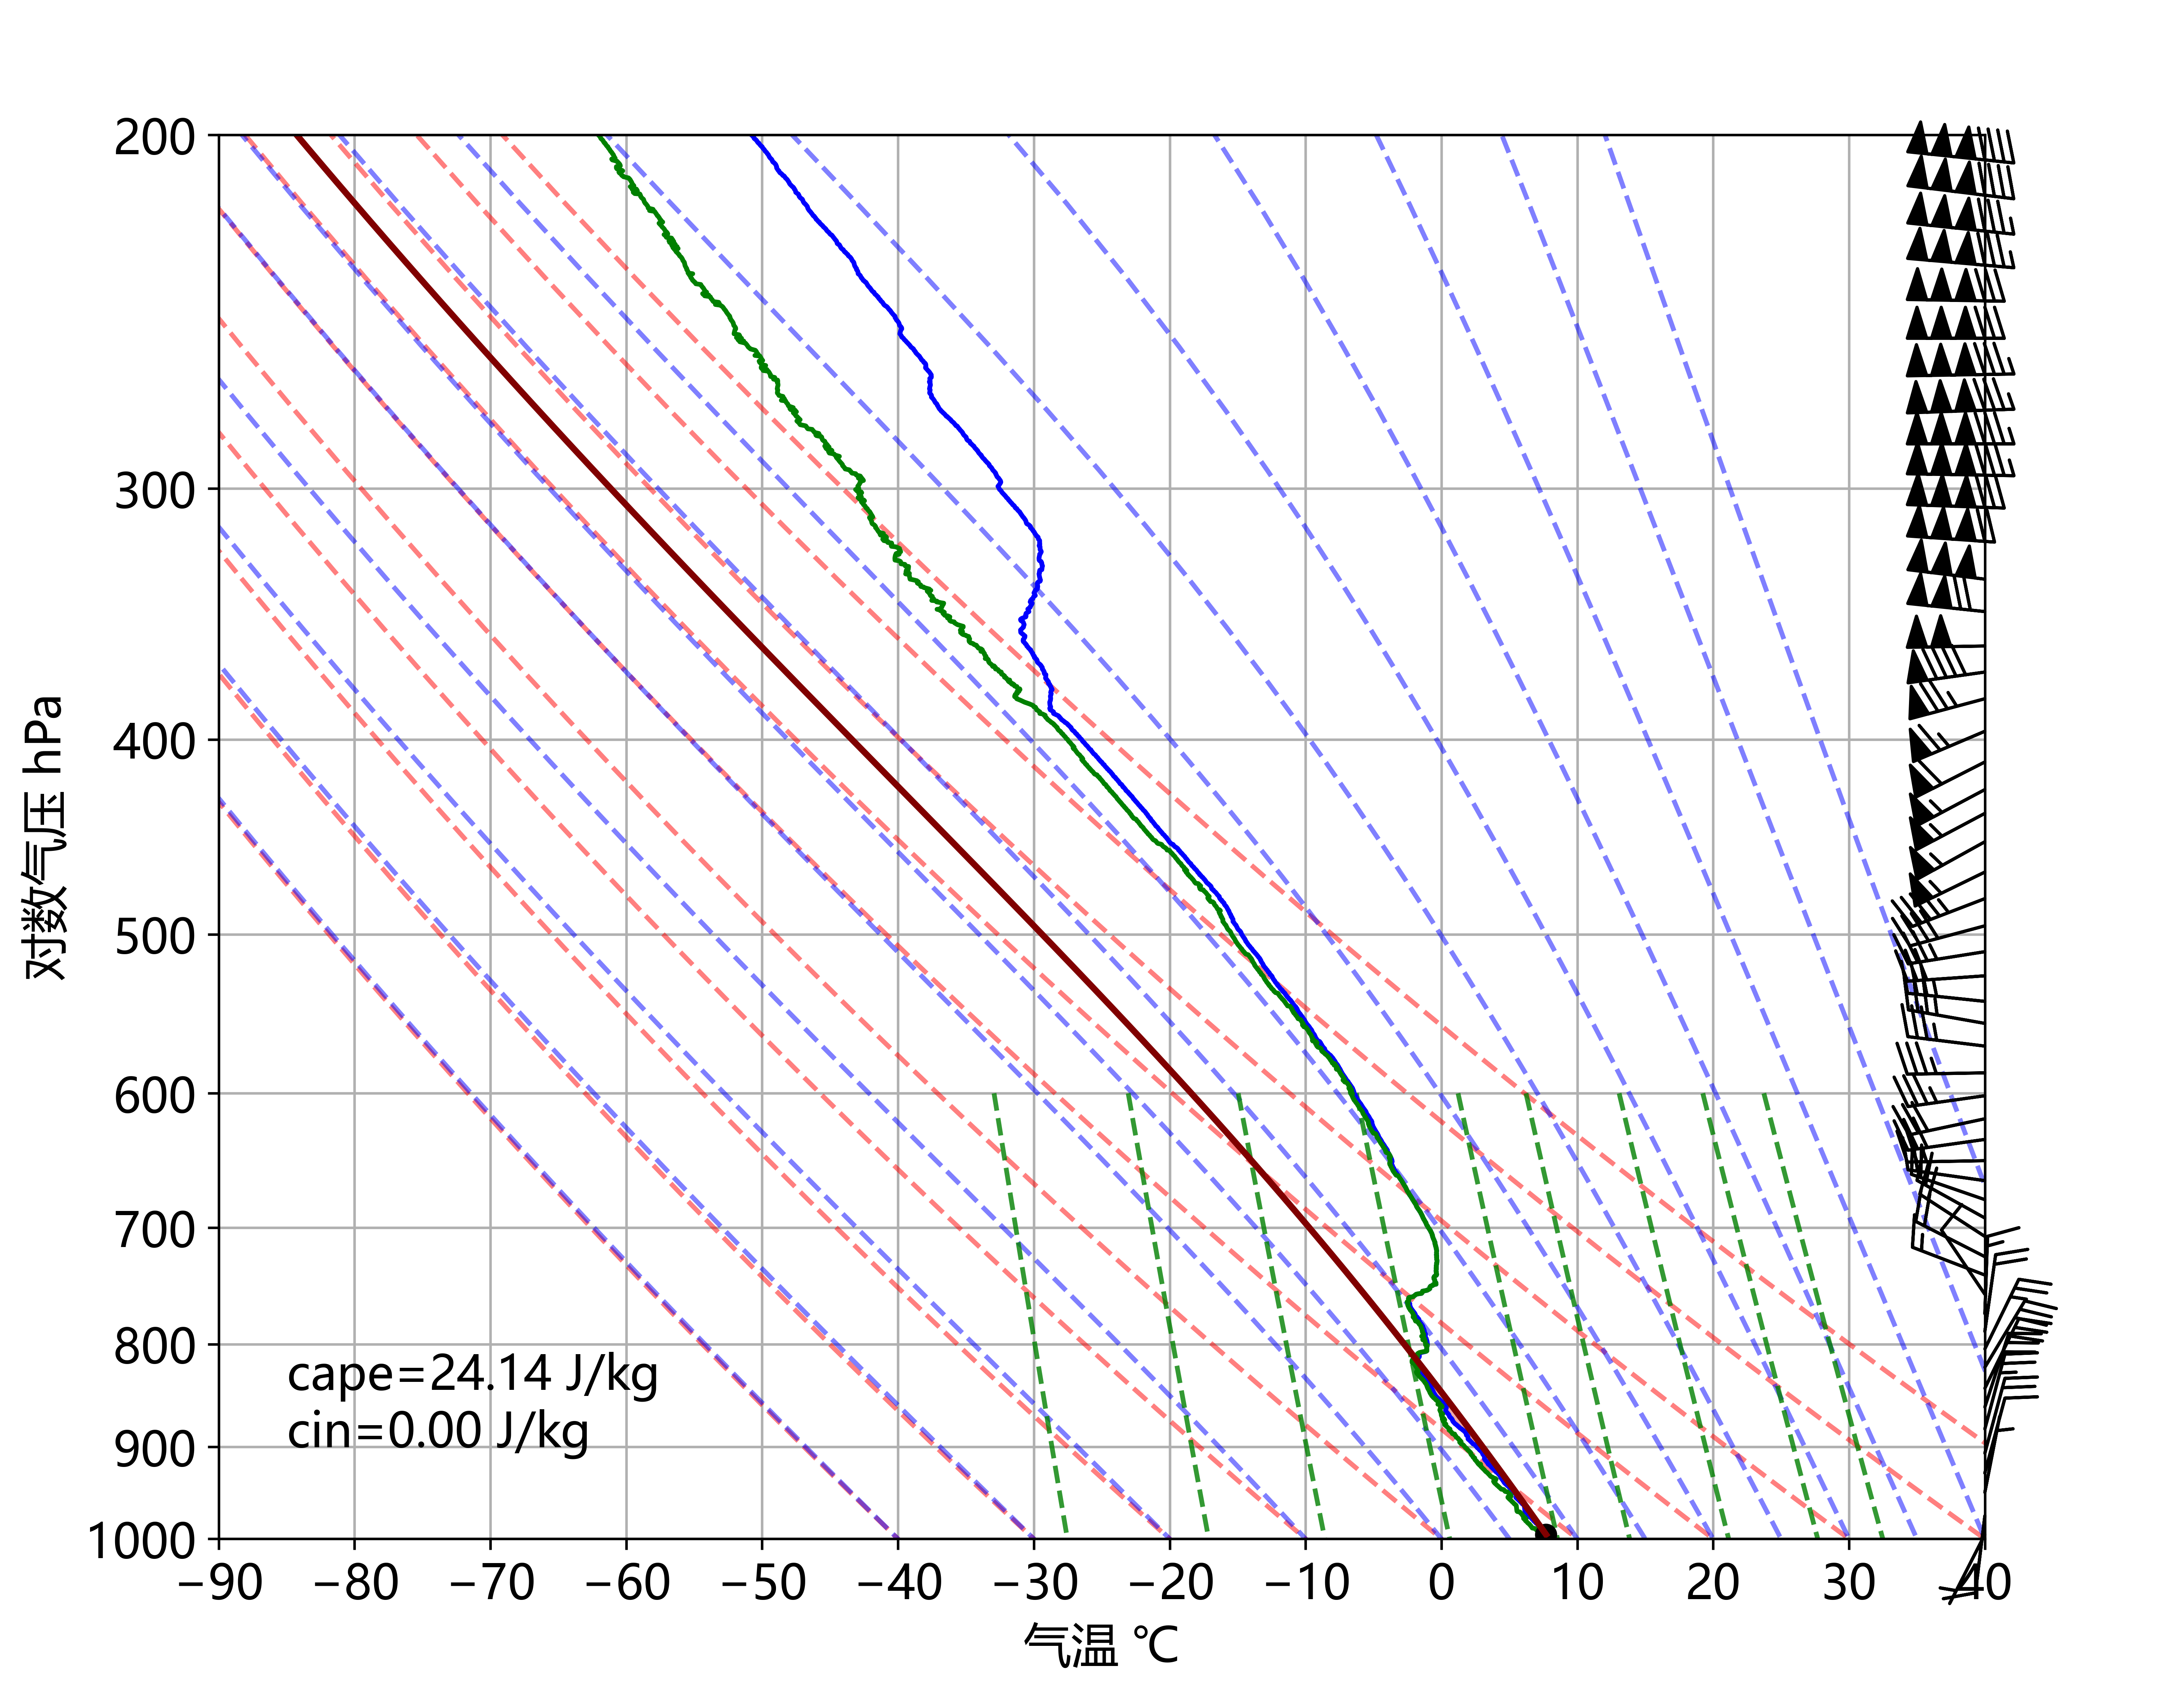

In [14]:
fig = plt.figure(figsize=(10, 8),dpi=600)

#注意 rotation 表示图像旋转，默认为 30度 ，旋转表示斜温图
skew = metpy.plots.SkewT(fig, rotation=0,aspect ='auto')

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_xlim(-90, 40)
skew.ax.set_ylim(1000, 200)

# 绘制 温度层结曲线
skew.plot(p, T, 'blue')

# 绘制 露点层结曲线
skew.plot(p, Td, 'green')
skew.plot_barbs(pw, u, v,barb_increments={'half': 2, 'full': 4, 'flag': 20},fill_empty=False)

#skew.ax.set_title((dti+timedelta(hours=8)).strftime('%Y年%m月%d日%H时 探空TlogP'),fontsize=18)
skew.ax.set_xlabel('气温 ℃',fontsize=15)
skew.ax.set_ylabel('对数气压 hPa',fontsize=15)


# 绘制 LCL 抬升凝结高度
lcl_pressure, lcl_temperature = metpy.calc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# 计算气块上升期的温度
prof = metpy.calc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'maroon', linewidth=2)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# 绘制  CAP、CIN
skew.shade_cin(p, T, prof, Td)
skew.shade_cape(p, T, prof)

cape,cin =metpy.calc.cape_cin(p, T, Td, prof)

skew.ax.text(-85,900,f'cape={cape.m:.2f} {cape.units:~P}\ncin={cin.m:.2f} {cin.units:~P}',fontsize=15)

# skew.ax.text(-85,900,f'cape={cape.m:.2f} {cape.units:~P}',fontsize=15)